# E8. Image Semantic Segmentation

### 실습 목차
1. Preparation with DeepLab V3+
2. Image Segmentation
3. Suggestions on improvements
4. Retrospective

## 1. Preparation with DeepLab V3+
- 실습에 필요한 모듈을 불러오고, 필요한 함수를 정의합니다.
- DeepLab V3+ 모델의 이미 학습된 가중치를 불러와서 image segmentation에 활용할 예정입니다.


In [ ]:
import cv2
import numpy as np
import os
import tarfile
import urllib
from matplotlib import pyplot as plt
import tensorflow as tf

In [ ]:
!ls

drive  sample_data


In [ ]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [ ]:
# DeepLab의 모델을 불러와서 segmentation에 활용합니다.
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '/content/drive/MyDrive/data_colab/e8_data/model'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /content/drive/MyDrive/data_colab/e8_data/model
model loaded successfully!


**필요한 함수 정의**

In [ ]:
# opencv로 이미지를 읽습니다.
def read(img):
  return cv2.imread(os.path.join(img_dir, img))

# DeepLab 모델에 학습하기 위해 resize한 이미지와 seg_map으로 '사람(혹은 강아지)'라벨만 mask로 추출합니다.
def mask_and_show(img_resized, seg_map):
  img_show = img_resized.copy()
  seg_map = np.where(seg_map == seg_map.max(), seg_map.max(), 0)   # segmentation에서 가장 값이 큰 영역을 추출합니다.
  img_mask = seg_map * (255/seg_map.max()) # 255 normalization
  img_mask = img_mask.astype(np.uint8)
  color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
  img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
  
  plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
  plt.show()

  return img_mask

# 이미지의 마스크와 경계가 뚜렷해지도록 합니다.
def mask_up(img_mask, img_orig):
  img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
  _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

  ax = plt.subplot(1,2,1)
  plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
  ax.set_title('Original Size Mask')

  ax = plt.subplot(1,2,2)
  plt.imshow(img_mask, cmap=plt.cm.binary_r)
  ax.set_title('DeepLab Model Mask')

  plt.show()

  return img_mask_up

# 원본 이미지를 블러처리합니다.
def blur(img_orig):
  img_orig_blur = cv2.blur(img_orig, (13,13))
  plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
  plt.show()
  return img_orig_blur

# 블러처리한 원본 이미지에 잘라낸 '사람'영역에다가 원래 이미지를 넣어줍니다.
def concat(img_mask_up, img_orig_blur, img_orig, file_name):
  img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
  img_bg_mask = cv2.bitwise_not(img_mask_color)
  img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
  plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
  plt.show()

  img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
  plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
  plt.show()
  print("image segmentation success".format(file_name))
  print("------------------------------\n")
  
  # 사람과 블러 처리한 배경을 합해준 이미지를 저장합니다.
  cv2.imwrite('/content/drive/MyDrive/data_colab/e8_data/blur_{}.png'.format(file_name), img_concat)

## 2. Image Segmentation
- DeepLab V3+ 모델을 활용하고, 위에서 정의한 함수를 활용해서 이미지 세그멘테이션을 진행합니다.

minji shape :  (1018, 1130, 3)
(1018, 1130, 3) (462, 513, 3) 15


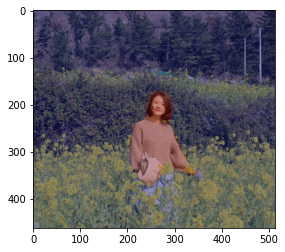

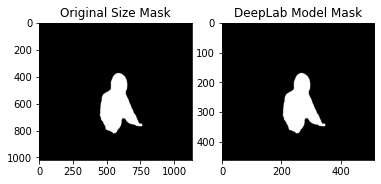

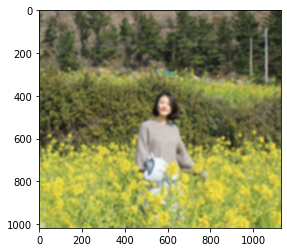

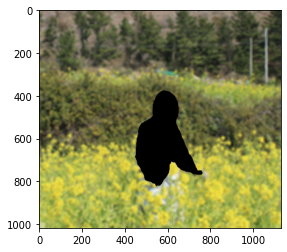

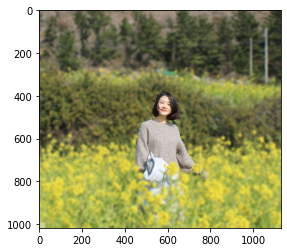

image segmentation success
------------------------------

dog shape :  (450, 720, 3)
(450, 720, 3) (320, 513, 3) 12


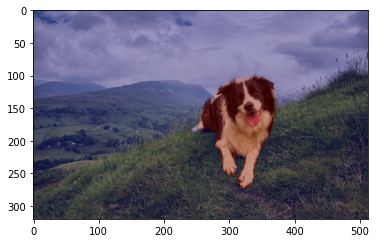

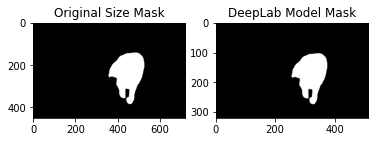

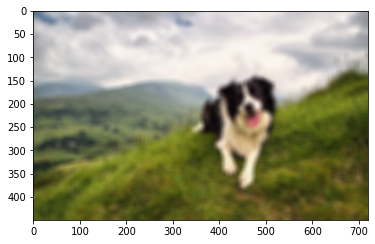

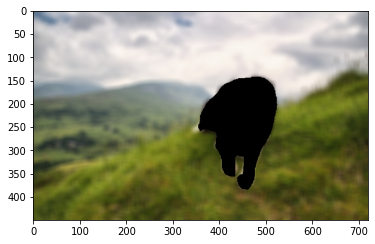

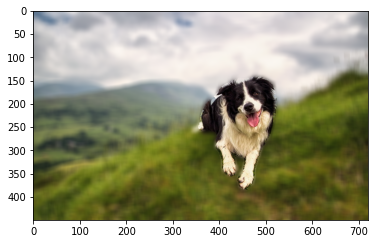

image segmentation success
------------------------------

volleyball shape :  (390, 559, 3)
(390, 559, 3) (357, 513, 3) 15


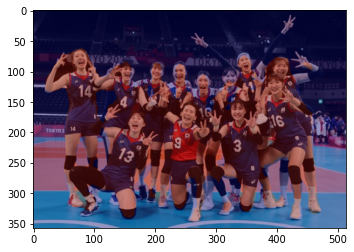

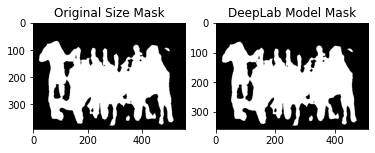

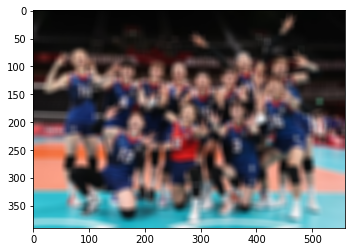

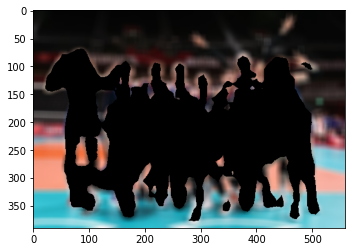

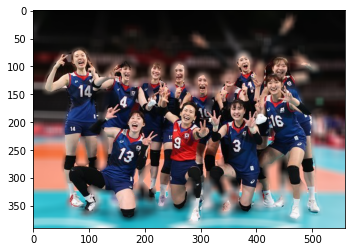

image segmentation success
------------------------------



In [ ]:
img_dir = '/content/drive/MyDrive/data_colab/e8_data/images'
file_list = os.listdir(img_dir)
img = {}

for file in file_list:
  if file == "background" : continue
  
  file_name = os.path.splitext(file)[0]
  img_orig = read(file)
  img[file_name] = img_orig
  print("{} shape : ".format(file_name),img_orig.shape)

  img_resized, seg_map = MODEL.run(img_orig)
  print(img_orig.shape, img_resized.shape, seg_map.max())

  img_mask = mask_and_show(img_resized, seg_map)
  img_mask_up = mask_up(img_mask, img_orig)
  img_orig_blur = blur(img_orig)
  concat(img_mask_up, img_orig_blur, img_orig, file_name)

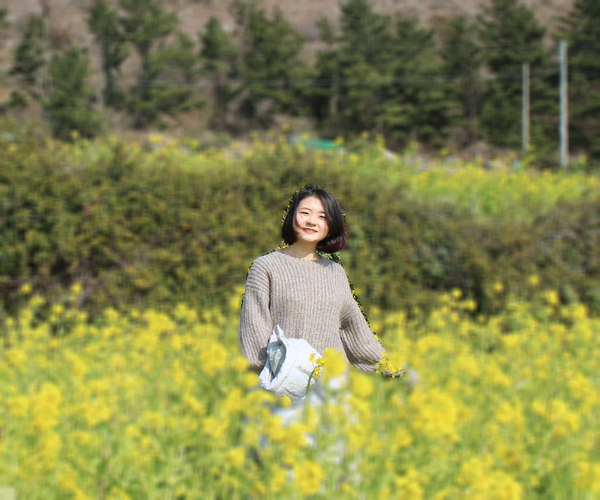

In [ ]:
from PIL import Image

target_size = (600,500)

Image.open("/content/drive/MyDrive/data_colab/e8_data/blur_minji.png").resize(target_size)

- 위 사진의 개선점     
> 1) 사람영역과 배경의 경계선에서 배경이 보이는 부분들이 깔끔하지 않습니다.   
> 2) 유채꽃밭에서 찍은 사진인데, 몇몇 유채꽃들이 blur되지 않았네요.

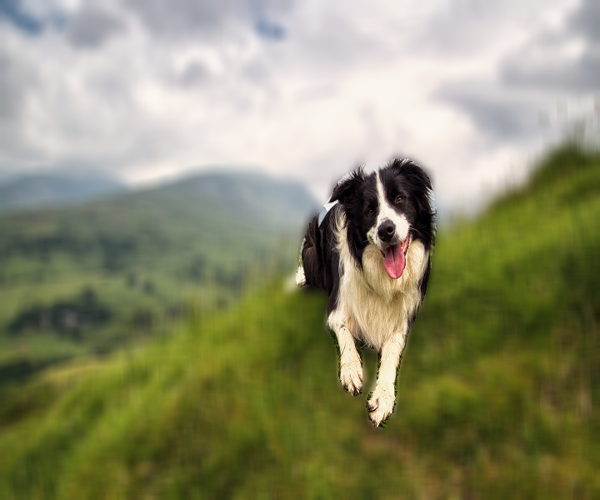

In [ ]:
Image.open("/content/drive/MyDrive/data_colab/e8_data/blur_dog.png").resize(target_size)

- 위 사진의 개선점
> 1) 마찬가지로 강아지와 주변 배경이 너무 뚝 잘라져나간 것 같고, 경계선의 처리가 개선되면 좋겠습니다.   
> 2) 강아지 꼬리랑 뒷다리가 좀 잘린 것 같습니다.

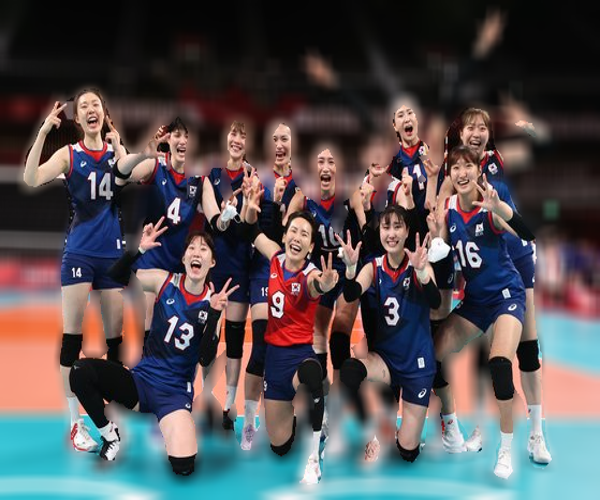

In [ ]:
Image.open("/content/drive/MyDrive/data_colab/e8_data/blur_volleyball.png").resize(target_size)

- 위 사진의 개선점
> 1) 2020 도쿄올림픽에서 제게 가장 인상깊었던 여자배구팀 단체사진입니다. 사람들이 어느정도 인식이 되었지만, 다리가 잘리거나 얼굴이 조금씩 잘려 있습니다.   
> 2) 또, 검출된 영역에 배경이 나오기도 해서 어색한 느낌이 듭니다. 전반적으로 자연스럽게 뒷배경이 셸로우 포커스 된 것 같지 않습니다.

(450, 720, 3) (320, 513, 3) 12


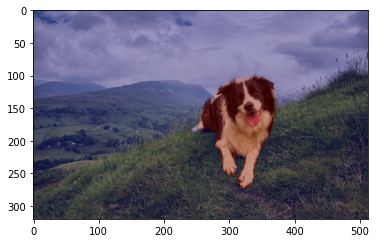

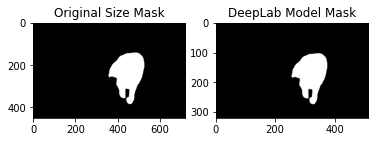

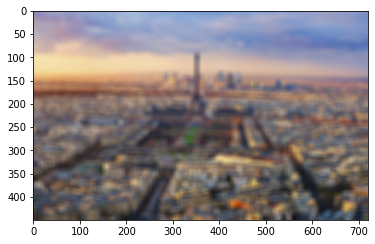

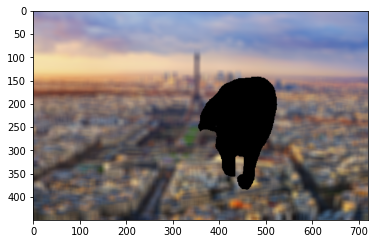

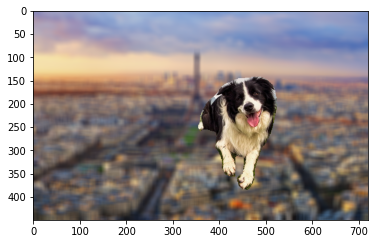

image segmentation success
------------------------------



In [ ]:
# 보더콜리와 함께 세계여행
img_orig = read('dog.jpeg')
img_background = read('background/paris.jpeg')
img_background = cv2.resize(img_background, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)

img_resized, seg_map = MODEL.run(img_orig)
print(img_orig.shape, img_resized.shape, seg_map.max())

img_mask = mask_and_show(img_resized, seg_map)
img_mask_up = mask_up(img_mask, img_orig)
img_orig_blur = blur(img_background)
concat(img_mask_up, img_orig_blur, img_orig, file_name)

(390, 559, 3) (357, 513, 3) 15


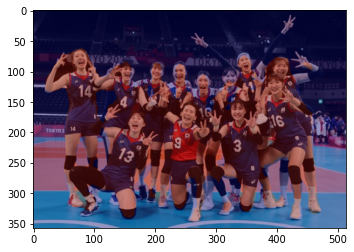

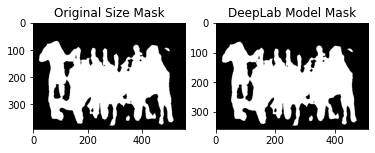

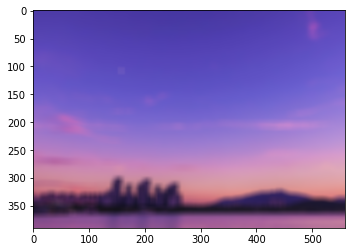

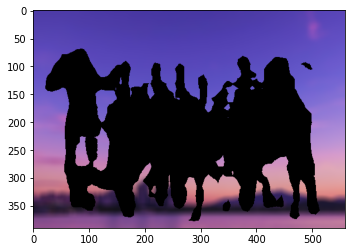

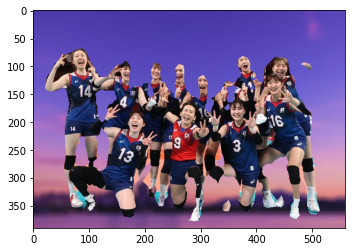

image segmentation success
------------------------------



In [ ]:
# 라라랜드 촬영지를 배경으로
img_orig = read('volleyball.jpeg')
img_background = read('background/lalaland_bg.jpeg')
img_background = cv2.resize(img_background, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)

img_resized, seg_map = MODEL.run(img_orig)
print(img_orig.shape, img_resized.shape, seg_map.max())

img_mask = mask_and_show(img_resized, seg_map)
img_mask_up = mask_up(img_mask, img_orig)
img_orig_blur = blur(img_background)
concat(img_mask_up, img_orig_blur, img_orig, file_name)

## 3. Suggestions on improvements
- semantic segmentation의 불완전함으로 인해 셸로우 포커싱이 자연스럽지 않은 문제가 발생합니다. 이를 해결하기 위해 노드에서 제안된 기술은 1) 3D Depth Camera, 2) Depth Image, 3) IR(적외선) 3D Depth Sensing 이 있습니다.

1) 3D Depth Camera    
해당 기술은 하드웨어의 도움을 필요로 하는 것 같습니다. 기존의 일반 카메라와 달리 2D로 이미지를 처리하지 않고, 3D로 이미지 픽셀의 깊이 값을 계산할 수 있는 기술이다. 크게 스테레오(두개의 2D 이미지 센서 결합), Tof, Structured Pattern 의 3가지 방식이 있다고 한다. 요점은, 결합 방식이든 광학적인 방식이든 3D로 이미지를 나타내준다는 것이다. 따라서, image segmentation을 위해 3D Depth Camera로 이미지를 입체적으로 구분할 수 있을 것 같습니다.

대상 - 3D Depth Camera로 촬영 - 3D 이미지 get - 원하는 이미지 영역(대상)을 3D depth에서 구분해내서 segmentation

2) Depth Image   
구글브레인에서 작성한 논문에 따르면, 이미지의 3d depth를 알아낼 수 있는 방법은 기존에는 supervised learning 이나 카메라 렌즈를 여러 개 사용함으로 가능했다고 합니다. 구글 브레인은 이에 unsupervised monocular 방식으로 알고리즘을 활용해 이미지의 depth를 찾아내고자 합니다. 이 방법은 robotics 에서 저렴한 카메라만 가지고도 로봇이 3d detection할 수 있는 유용성이 있다고 합니다. 이것을 image segmentation에 적용하는 방법은, 촬영한 이미지에 알고리즘을 적용해 3d depth를 구분한 후, 그 depth에서 잘라내고자 하는 대상을 잘라내는 방법이 있을 것 같습니다.

대상 - monocular 카메라로 촬영 - unsupervised algorithm으로 이미지의 3D depth 찾아내기 - 원하는 대상을 3D depth 에서 구분해서 segmentation


## 4. Retrospective 
이미지를 잘라내서 배경을 흐리게 또는 배경을 바꾸는 것은 즐거운 일인 것 같습니다. 하지만 이미지에서 픽셀 단위로 원하는 영역을 구분해낼 때 문제가 발생합니다. (DeepLabV3+) 자르고자 하는 대상(사람, 강아지 등)의 경계가 깔끔하게 구분되지 않고, 잘못 포함된 부분들이 발생해서 부자연스럽습니다. 이를 개선하고자 3D 깊이로 물체를 표현해본다면, depth가 구분되는 영역이 조금 더 명확해져서 자연스러운 이미지 세그멘테이션이 가능할 것으로 생각됩니다.